In [12]:
!pip install pydot

  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/7f/90/c9b51f3cdff89cd8f93382060330f43d1af098a6624cff439e700791e922/pydot-2.0.0-py3-none-any.whl.metadata


## Import Packages and load dataset

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GaussianNoise, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Load and preprocess the dataset
KDDTrain = pd.read_csv('training.csv')
KDDTest = pd.read_csv('testing.csv')

In [136]:
# Distribution of attack classes in training dataset
KDDTrain['class'].value_counts()

class
0    67343
1    58630
Name: count, dtype: int64

In [137]:
# Distribution of attack classes in testing dataset
KDDTest['class'].value_counts()

class
1    12833
0     9711
Name: count, dtype: int64

## Extract the samples and labels

In [2]:
X_train = KDDTrain.drop('class',axis=1).values
#y_train = KDDTrain['class'].values
X_test = KDDTest.drop('class',axis=1).values
y_test = KDDTest['class'].values

In [61]:
''''
# Assuming the normal data (label 0) is used to train the autoencoder
train_normal = KDDTrain[(KDDTrain['class']) == 0]
X_train_normal = train_normal.drop('class',axis=1).values
y_train_normal = train_normal['class'].values

In [ ]:
''''
rint(X_train.shape)
#print(y_train.shape)
print(X_train_normal.shape)
print(y_train_normal.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
''''
#Used this code for extracting the normal samples and validation split
#Already stored the samples
# Assuming the normal data (label 0) is used to train the autoencoder
train_normal = KDDTrain[(KDDTrain['class']) == 0]
X_train_normal = train_normal.drop('class',axis=1).values


# split into train val sets
X_train_normal, X_val_normal = train_test_split(X_train_normal, test_size=0.25)

X_train_normal = pd.DataFrame(X_train_normal)
X_val_normal = pd.DataFrame(X_val_normal)

X_train_normal.to_csv('X_train_normal_75.csv', index=False)
X_val_normal.to_csv('X_val_normal_25.csv', index=False)

In [280]:
''''
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

# Load and preprocess the dataset
X_train_normal = pd.read_csv('X_train_normal_75.csv')
X_val_normal = pd.read_csv('X_val_normal_25.csv')

# Define the autoencoder architecture (snippet of the architecture where changes were made)
input_dim = X_train_normal.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(25, activation='selu')(input_layer)
encoder = GaussianNoise(0.15)(encoder)
encoder = Dropout(0.05)(encoder)

bottleneck = Dense(15, activation='selu')(encoder)

decoder = Dense(25, activation='selu')(bottleneck)

decoder = Dense(input_dim, activation='selu')(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer=RMSprop(learning_rate=0.0035), loss='mse') 

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the autoencoder
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=10,
                          batch_size=32,
                          shuffle=True,                        
                          validation_data=(X_val_normal,X_val_normal),
                          verbose=1,
                          callbacks=[early_stopping])

# define an encoder model (without the decoder)
encoder = Model(inputs=input_layer, outputs=bottleneck)
# save the encoder to file
#encoder.save('encoder.h5')
autoencoder.save('autoencoder.keras')

Epoch 1/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8722 - val_loss: 0.0979
Epoch 2/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0751 - val_loss: 0.0413
Epoch 3/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0508 - val_loss: 0.0891
Epoch 4/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0394 - val_loss: 0.0255
Epoch 5/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0328 - val_loss: 0.0307
Epoch 6/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0289 - val_loss: 0.0223
Epoch 7/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0270 - val_loss: 0.0340
Epoch 8/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0245 - val_loss: 0.0351
Epoch 9/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0233 - val_loss: 0.0261
Epoch 10/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0222 - val_loss: 0.0301


## Load the model and training samples

In [3]:
import numpy as np
import pandas as pd
from keras.models import load_model

# Load and preprocess the dataset
X_train_normal = pd.read_csv('X_train_normal_75.csv')
X_val_normal = pd.read_csv('X_val_normal_25.csv')

# Load the model from file
autoencoder = load_model('autoencoder.keras')

In [257]:
''''
# Rename the model
autoencoder.name = 'autoencoder'
# Rename the autoencoder layers
autoencoder.layers[0].name = 'input_layer'
autoencoder.layers[1].name = 'encode_layer'
autoencoder.layers[2].name = 'gaussian_noise'
autoencoder.layers[3].name = 'dropout'
autoencoder.layers[4].name = 'bottleneck_layer'
autoencoder.layers[5].name = 'decode_layer'
autoencoder.layers[6].name = 'output_layer'

## Analyse the Autoencoder

In [28]:
# Print the model's architecture
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encode_layer (Dense)                 │ (None, 25)                  │           1,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_layer (Dense)             │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decode_layer (Dense)                 │ (None, 25)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 40)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,712 (22.32 KB)

 Trainable params: 2,855 (11.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,857 (11.16 KB)

In [13]:
autoencoder.layers[1].get_config()

{'name': 'encode_layer',
 'trainable': True,
 'dtype': 'float32',
 'units': 25,
 'activation': 'selu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [12]:
autoencoder.layers[1].get_weights()

[array([[-2.24216178e-01,  4.06607181e-01, -4.53795642e-01,
         -1.68279290e-01,  8.64176869e-01, -4.45549965e-01,
          1.84867866e-02,  5.89235723e-01,  2.81428397e-01,
         -6.59231901e-01,  2.53764451e-01,  4.02509391e-01,
          6.11863993e-02, -1.96655333e-01,  5.17043285e-02,
          1.09065138e-01,  5.10363936e-01, -2.17693448e-01,
          3.14938217e-01, -4.81891185e-02,  2.80469149e-01,
          1.40274167e-01, -1.30120859e-01,  1.45161763e-01,
          2.59050667e-01],
        [ 3.56391072e-01, -2.86322325e-01,  5.55643320e-01,
          3.22234243e-01,  5.17575920e-01,  2.98172742e-01,
         -3.33697945e-02, -8.18567723e-02, -7.01615870e-01,
          1.04165125e+00,  3.15468371e-01,  2.27952525e-01,
          1.71598661e+00,  2.75147885e-01, -6.62710741e-02,
         -1.04946983e+00, -4.82889116e-01,  1.36667669e+00,
         -1.30734336e+00, -8.99542868e-01, -6.41318262e-02,
         -6.12574041e-01, -1.20152391e-01, -8.50447297e-01,
         -2.2

In [264]:
for layer in autoencoder.layers:
    print(layer.name)
    print("Layer Configuration:")
    print(layer.get_config())
    print("Layer Weights:")
    print(layer.get_weights())

input_layer
Layer Configuration:
{'batch_shape': (None, 40), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}
Layer Weights:
[]
encode_layer
Layer Configuration:
{'name': 'encode_layer', 'trainable': True, 'dtype': 'float32', 'units': 25, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Layer Weights:
[array([[-2.24216178e-01,  4.06607181e-01, -4.53795642e-01,
        -1.68279290e-01,  8.64176869e-01, -4.45549965e-01,
         1.84867866e-02,  5.89235723e-01,  2.81428397e-01,
        -6.59231901e-01,  2.53764451e-01,  4.02509391e-01,
         6.11863993e-02, -1.96655333e-01,  5.17043285e-02,
         1.09065138e-01,  5.10363936e-0

In [265]:
optimizer_config = autoencoder.optimizer.get_config()
print("Optimizer Configuration:")
print(optimizer_config)

Optimizer Configuration:
{'name': 'rmsprop', 'learning_rate': 0.0035000001080334187, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': 100, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}


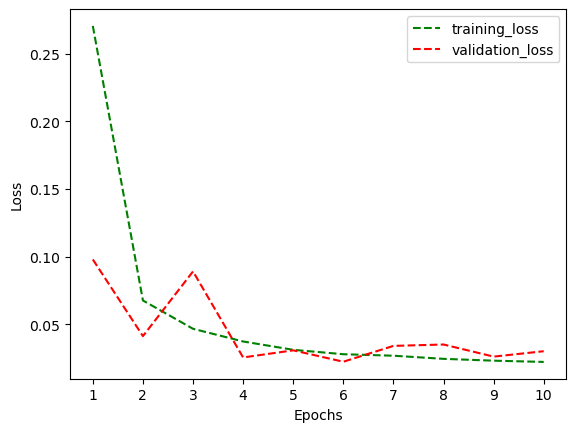

In [283]:
from matplotlib import pyplot

# Plot training loss
pyplot.figure()

# Plot Training Loss
pyplot.plot(history.history['loss'], label='training_loss', linestyle='--',color='green')
pyplot.plot(history.history['val_loss'], label='validation_loss', linestyle='--',color='red')
pyplot.xticks(np.arange(0, 10, step=1), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.savefig('Training and validation loss.png')
pyplot.show()

In [282]:
# Extract the validation loss for each epoch
min(history.history['val_loss'])

0.02232281118631363

In [284]:
# Predict on the validation set
val_reconstructed = autoencoder.predict(X_val_normal)
val_mse = np.mean(np.power(X_val_normal - val_reconstructed, 2), axis=1)
error_df_val = pd.DataFrame({'reconstruction_error': val_mse,
                         'true_class': 0})

527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [285]:
val_reconstructed

array([[ 1.96462162e-02,  9.47744608e-01,  1.99831047e+01, ...,
         3.49989645e-02,  1.09654584e-03,  7.61355460e-03],
       [-1.52366683e-01,  2.10517955e+00,  1.13785009e+01, ...,
         4.33691591e-02,  7.77314301e-04,  1.09501995e-01],
       [-1.63221229e-02,  1.00422215e+00,  2.41337891e+01, ...,
         5.11842631e-02, -4.32019271e-02,  1.23820622e-02],
       ...,
       [ 4.31356803e-02,  9.27519679e-01,  2.02874489e+01, ...,
         2.12560762e-02, -9.82320216e-03,  1.78339947e-02],
       [-3.63928266e-03,  9.96958017e-01,  2.41574745e+01, ...,
         4.60289605e-02, -4.74784449e-02,  1.29035935e-02],
       [ 1.19776897e-01,  1.65510929e+00,  4.78463898e+01, ...,
         5.40307984e-02,  5.33849001e-02,  4.70822789e-02]], dtype=float32)

In [286]:
val_reconstructed.shape

(16836, 40)

In [287]:
val_mse

0        0.001940
1        0.014529
2        0.002486
3        0.003191
4        0.048621
           ...   
16831    0.063385
16832    0.017749
16833    0.006478
16834    0.002876
16835    0.048087
Length: 16836, dtype: float64

In [288]:
val_mse.shape

(16836,)

In [289]:
val_mse.mean()

0.022328661672704194

In [290]:
error_df_val

,reconstruction_error,true_class
0,0.001940,0
1,0.014529,0
2,0.002486,0
3,0.003191,0
4,0.048621,0
...,...,...
16831,0.063385,0
16832,0.017749,0
16833,0.006478,0
16834,0.002876,0


In [291]:
error_df_val.describe()

,reconstruction_error,true_class
count,16836.000000,16836.0
mean,0.022329,0.0
std,0.039140,0.0
min,0.001648,0.0
25%,0.002785,0.0
50%,0.003955,0.0
75%,0.020042,0.0
max,1.253442,0.0


## Prediction on Test Dataset

In [4]:
# Predict on the test set
test_reconstructed = autoencoder.predict(X_test)
test_mse = np.mean(np.power(X_test - test_reconstructed, 2), axis=1)
error_df_test = pd.DataFrame({'reconstruction_error': test_mse,
                         'true_class': y_test})

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [5]:
# Find the threshold based on the validation set
threshold = 0.0223 # best(min mse, mse graph)   #0.02


# Predict the anomaly (1 for attack, 0 for normal)
y_pred = [1 if e > threshold else 0 for e in error_df_test['reconstruction_error'].values]

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      9711
           1       0.90      0.96      0.93     12833

    accuracy                           0.91     22544
   macro avg       0.92      0.91      0.91     22544
weighted avg       0.91      0.91      0.91     22544



In [12]:
from sklearn.metrics import matthews_corrcoef
# Calculate MCC
mcc_score = matthews_corrcoef(y_test, y_pred)
print("MCC Score:", mcc_score)

MCC Score: 0.821942501468967


In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, auc

outputFile=open('Autoencoder Model Results.txt','a')
confusion= confusion_matrix(y_test, y_pred)

#Overall Accuracy
Accuracy_cla= accuracy_score(y_test, y_pred)
#Precision
Pr_cla=precision_score(y_test, y_pred)
#Sensivity/Recall/TPR
Sn_cla= recall_score(y_test, y_pred)
#F1 Score
F1_cla = f1_score(y_test, y_pred)

#Compute MCC
MCC_cla = matthews_corrcoef(y_test, y_pred)


Results='Independent Test Results:\n'
outputFile.write(str(Results))

print("\nConfusion Matrix")
print("{0}".format(confusion_matrix(y_test, y_pred)))
outputFile.write('Overall Accuracy = %.5f\n'%Accuracy_cla)
outputFile.write('Precision = %.5f\n'%Pr_cla)
outputFile.write('Sensivity/Recall/TPR = %.5f\n'%Sn_cla)
outputFile.write('F1 Score = %.5f\n'%F1_cla)
outputFile.write('MCC = %.5f\n'%MCC_cla)
print("\nClassification Report")
print("{0}".format(classification_report(y_test, y_pred)))

outputFile.close()


Confusion Matrix
[[ 8296  1415]
 [  560 12273]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      9711
           1       0.90      0.96      0.93     12833

    accuracy                           0.91     22544
   macro avg       0.92      0.91      0.91     22544
weighted avg       0.91      0.91      0.91     22544



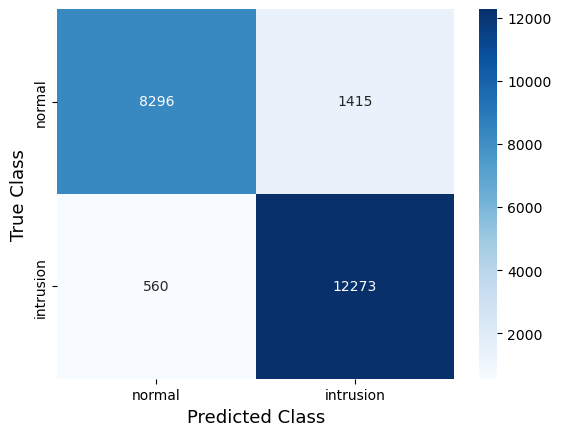

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion,
            cmap='Blues',
			annot=True,
			fmt='g',
			xticklabels=['normal', 'intrusion'],
			yticklabels=['normal', 'intrusion'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
plt.savefig('Confusion Matrix for binary Class',dpi=500);
plt.show()

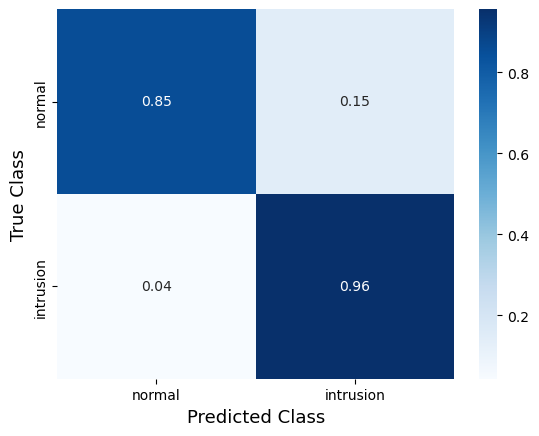

In [8]:
#Normalized confusion matrix
#Divide each row element by the sum of the entire row
cm_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized,
            cmap='Blues',
			annot=True,
			fmt='.2f',
			xticklabels=['normal', 'intrusion'],
			yticklabels=['normal', 'intrusion'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
plt.show()

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.953074801528853


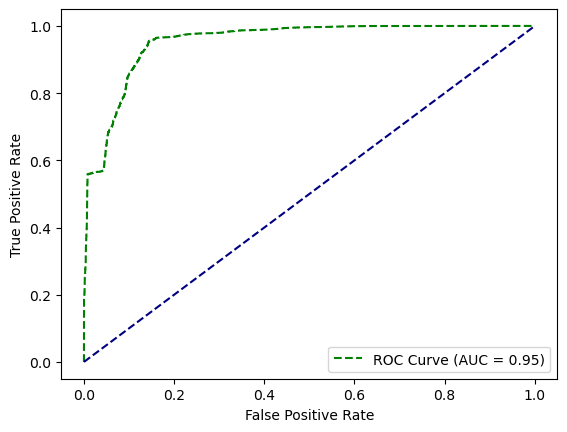

In [11]:
# Prediction and error calculation
from sklearn.metrics import roc_auc_score

reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# Normalize MSE to convert to pseudo-probabilities
min_error = np.min(mse)
max_error = np.max(mse)
mse_normalized = (mse - min_error) / (max_error - min_error)
pred_prob = mse_normalized

fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

print(roc_auc_score(y_test, pred_prob))

# Plot ROC curve
plt.figure()
#lw = 1
plt.plot(fpr, tpr, linestyle='--',color='green', label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--',color='navy')
#plt.xlim([0.0, 1.05])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig('ROC Curve for Autoencoder',dpi=500);

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.9600462200294544


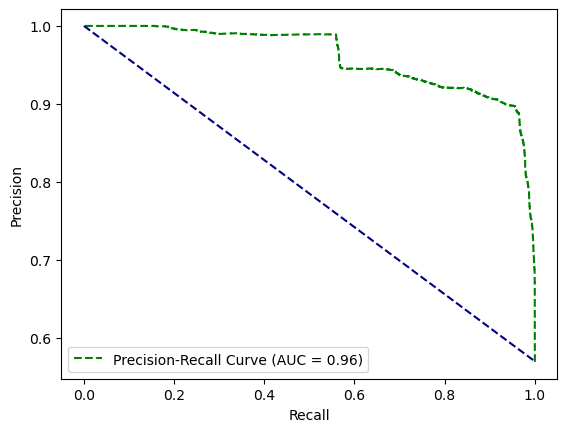

In [12]:
from sklearn.metrics import average_precision_score, precision_recall_curve

# Prediction and error calculation
reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)

# Normalize MSE to convert to pseudo-probabilities
min_error = np.min(mse)
max_error = np.max(mse)
mse_normalized = (mse - min_error) / (max_error - min_error)
pred_prob = mse_normalized

precision, recall, thresh = precision_recall_curve(y_test, pred_prob)
pr_auc = auc(recall, precision)

print(average_precision_score(y_test, pred_prob))

# plotting
plt.figure()
#lw = 1
plt.plot(recall, precision, linestyle='--',color='green', label='Precision-Recall Curve (AUC = %0.2f)' % pr_auc)
plt.plot([0, 1], [1, 0.57], linestyle='--',color='navy') #for anonaly (1) 12833/22544 = 0.56924

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.savefig('Precision-Recall Curve for Autoencoder',dpi=500);

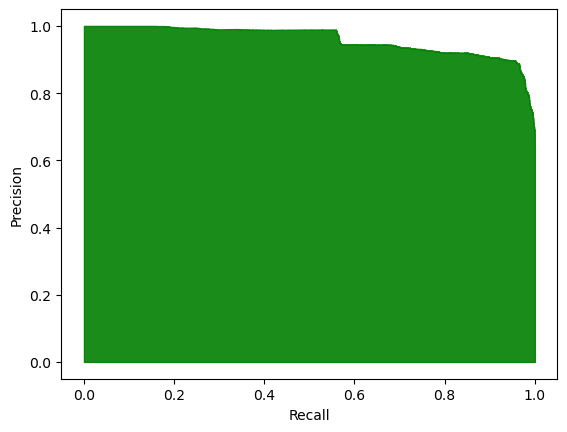

In [13]:
plt.fill_between(recall, precision, color='green',alpha=0.9)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('Precision-Recall Curve for Autoencoder_2',dpi=500);
plt.show()